## Importing necessary libraries

In [1]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.io import loadmat
import os
from pywt import wavedec
from functools import reduce
from scipy import signal
from scipy.stats import entropy
from scipy.fft import fft, ifft
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow import keras as K
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,cross_validate
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
from tensorflow import keras
from sklearn.model_selection import cross_val_score
from tensorflow.keras.layers import Conv1D,Conv2D,Add
from tensorflow.keras.layers import MaxPool1D, MaxPooling2D
import seaborn as sns

C:\Users\Dark\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Reading EEG data along with Subject Demographics

In [2]:
data = pd.read_csv("EEG_data.csv")
data

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12806,9.0,9.0,64.0,38.0,-39.0,127574.0,9951.0,709.0,21732.0,3872.0,39728.0,2598.0,960.0,1.0,0.0
12807,9.0,9.0,61.0,35.0,-275.0,323061.0,797464.0,153171.0,145805.0,39829.0,571280.0,36574.0,10010.0,1.0,0.0
12808,9.0,9.0,60.0,29.0,-426.0,680989.0,154296.0,40068.0,39122.0,10966.0,26975.0,20427.0,2024.0,1.0,0.0
12809,9.0,9.0,60.0,29.0,-84.0,366269.0,27346.0,11444.0,9932.0,1939.0,3283.0,12323.0,1764.0,1.0,0.0


In [3]:
df = pd.read_csv('demographic_info.csv')
demo_data=df.drop(df.columns[2], axis=1)


## Combining the 2 CSV files on SubjectID

In [4]:
demo_data = demo_data.rename(columns = {'subject ID': 'SubjectID'})
new_data = data.merge(demo_data,how = 'inner',on = 'SubjectID')
new_data.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln,age,gender
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,25,M
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,25,M
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,25,M
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0,25,M
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0,25,M


It was mentioned in the Description of the Dataset that features like 'VideoID' and 'SubjectID'. The SubjectID and VideoID will provide hinderance while model training as there are 10 clips for 10 students and these 1-2 min clips are divided ino parts of 0.5 sec samples. So Model will most probably learn based on IDs but we want it to learn on based of EEG recordings, ethinicity and gender and age parameters.

## Defining necessary features for model training

In [5]:
new_data.drop(columns = ['SubjectID','VideoID','predefinedlabel'],inplace=True)

In [6]:
new_data

,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,user-definedlabeln,age,gender
0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,25,M
1,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,25,M
2,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,25,M
3,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,25,M
4,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,25,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12806,64.0,38.0,-39.0,127574.0,9951.0,709.0,21732.0,3872.0,39728.0,2598.0,960.0,0.0,24,F
12807,61.0,35.0,-275.0,323061.0,797464.0,153171.0,145805.0,39829.0,571280.0,36574.0,10010.0,0.0,24,F
12808,60.0,29.0,-426.0,680989.0,154296.0,40068.0,39122.0,10966.0,26975.0,20427.0,2024.0,0.0,24,F
12809,60.0,29.0,-84.0,366269.0,27346.0,11444.0,9932.0,1939.0,3283.0,12323.0,1764.0,0.0,24,F


## One hot encoding categorical variables

The Categorical variables here include 'Gender'.

In [7]:
data = pd.get_dummies(new_data)

In [8]:
data.dropna()
type(data)

pandas.core.frame.DataFrame

In [9]:
y= data.pop('user-definedlabeln')
x= data

In [10]:
y

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
12806    0.0
12807    0.0
12808    0.0
12809    0.0
12810    0.0
Name: user-definedlabeln, Length: 12811, dtype: float64

In [11]:
x

,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,age,gender_F,gender_M
0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,25,0,1
1,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,25,0,1
2,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,25,0,1
3,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,25,0,1
4,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,25,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12806,64.0,38.0,-39.0,127574.0,9951.0,709.0,21732.0,3872.0,39728.0,2598.0,960.0,24,1,0
12807,61.0,35.0,-275.0,323061.0,797464.0,153171.0,145805.0,39829.0,571280.0,36574.0,10010.0,24,1,0
12808,60.0,29.0,-426.0,680989.0,154296.0,40068.0,39122.0,10966.0,26975.0,20427.0,2024.0,24,1,0
12809,60.0,29.0,-84.0,366269.0,27346.0,11444.0,9932.0,1939.0,3283.0,12323.0,1764.0,24,1,0


## Normalization of the data

graph before normalization

<AxesSubplot:>

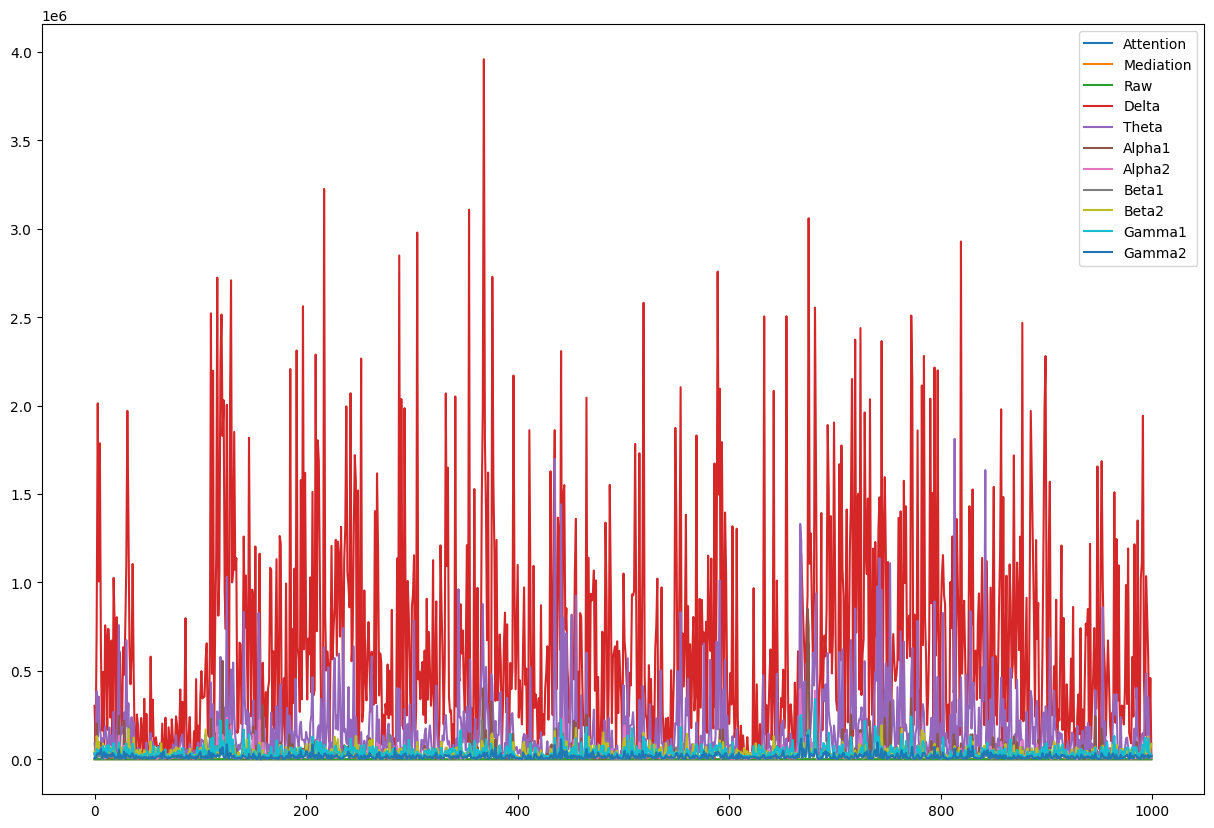

In [12]:
x.iloc[:1000,:11].plot(figsize = (15,10))

The scale of some EEG features were wide, so we use Z-score normalization.

In [13]:
x = StandardScaler().fit_transform(x)

After Normalization

<AxesSubplot:>

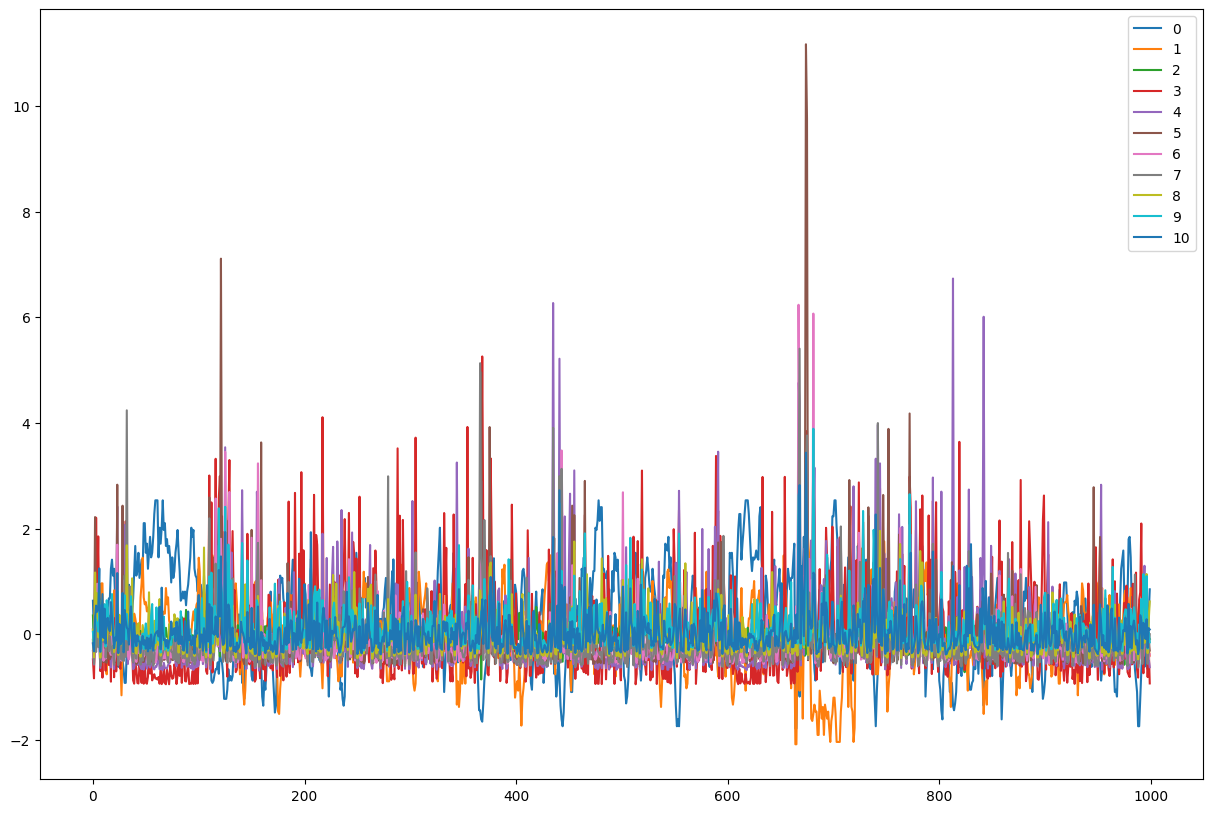

In [14]:
pd.DataFrame(x).iloc[:1000,:11].plot(figsize = (15,10))

## Dividing into Training and Validation sets

In [15]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.15)

In [16]:
x_train.shape, x_test.shape,y_train.shape,y_test.shape

((10889, 14), (1922, 14), (10889,), (1922,))

## Reshaping the data as required by the model

In [17]:
x_train = np.array(x_train).reshape(-1,14,1)
x_test = np.array(x_test).reshape(-1,14,1)

In [18]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((10889, 14, 1), (1922, 14, 1), (10889,), (1922,))

## Defining the Model's architecture

In [19]:
inputs = tf.keras.Input(shape=(14,1))

Dense1 = Dense(64, activation = 'relu',kernel_regularizer=keras.regularizers.l2())(inputs)

#Dense2 = Dense(128, activation = 'relu',kernel_regularizer=keras.regularizers.l2())(Dense1)
#Dense3 = Dense(256, activation = 'relu',kernel_regularizer=keras.regularizers.l2())(Dense2)

lstm_1=  Bidirectional(LSTM(256, return_sequences = True))(Dense1)
drop = Dropout(0.3)(lstm_1)
lstm_3=  Bidirectional(LSTM(128, return_sequences = True))(drop)
drop2 = Dropout(0.3)(lstm_3)

flat = Flatten()(drop2)

#Dense_1 = Dense(256, activation = 'relu')(flat)
Dense_2 = Dense(128, activation = 'relu')(flat)
outputs = Dense(1, activation='sigmoid')(Dense_2)

model = tf.keras.Model(inputs, outputs)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14, 64)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 14, 512)        │       657,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 14, 256)        │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3584)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       458,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,772,929 (6.76 MB)

 Trainable params: 1,772,929 (6.76 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
import pydot
import graphviz
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [48]:
def train_model(model,x_train, y_train,x_test,y_test, save_to, epoch = 2):

        opt_adam = keras.optimizers.Adam(learning_rate=0.001)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        mc = ModelCheckpoint(save_to + 'exp_01.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))
        
        model.compile(optimizer=opt_adam,
                  loss=['binary_crossentropy'],
                  metrics=['accuracy'])
        
        history = model.fit(x_train,y_train,
                        batch_size=20,
                        epochs=epoch,
                        validation_data=(x_test,y_test),
                        callbacks=[es,mc,lr_schedule])
        
        return model,history

## Training the Model

The loss function used will be 'Binary CrossEntropy'. We will be using callback functions like Early_Stopping to avoid overfitting and lr_scheduler to change the learning rate while model trains.

We will be training for 100 epochs starting with learning_rate = 0.001 and batch_size = 20.

In [49]:
model,history = train_model(model, x_train, y_train,x_test, y_test, save_to= './', epoch = 25) 

Epoch 1/25
543/545 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5128 - loss: 0.6929
Epoch 1: val_accuracy improved from -inf to 0.50937, saving model to ./exp_01.keras
545/545 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.5128 - loss: 0.6929 - val_accuracy: 0.5094 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 2/25
544/545 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5122 - loss: 0.6929
Epoch 2: val_accuracy did not improve from 0.50937
545/545 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.5122 - loss: 0.6929 - val_accuracy: 0.5094 - val_loss: 0.6930 - learning_rate: 9.0484e-04
Epoch 3/25
545/545 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5116 - loss: 0.6929
Epoch 3: val_accuracy did not improve from 0.50937
545/545 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.5116 - loss: 0.6929 - val_accuracy: 0.5094 - val_loss: 0.6930 - learning_rate: 8.1873e-04
Epoch 4/25
544/545 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5159 - loss: 0.6927
Epoch 4: val_accuracy did not

## Plotting the Training and Validation Accuracy along with losses

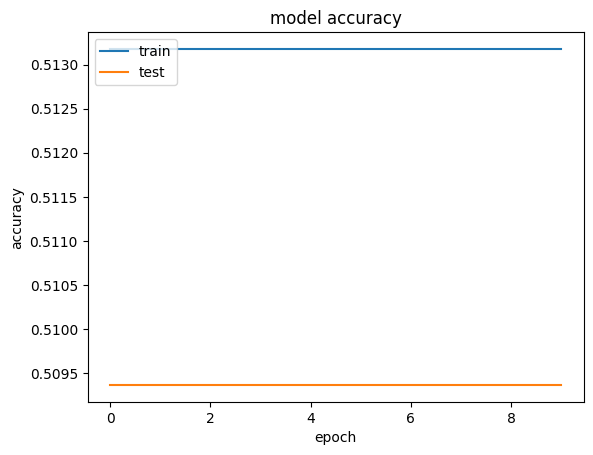

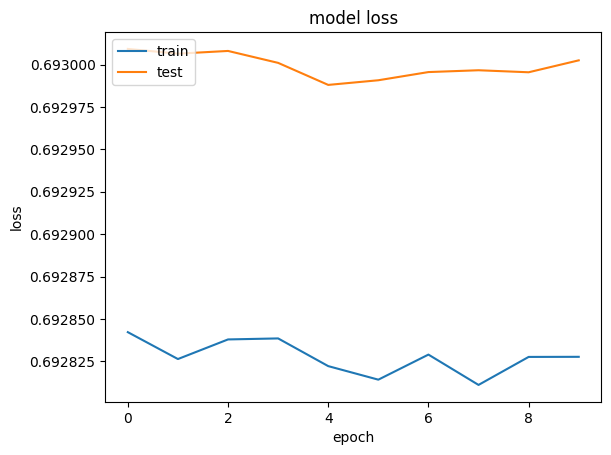

In [50]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [52]:
model.export("export_model")

INFO:tensorflow:Assets written to: export_model\assets


INFO:tensorflow:Assets written to: export_model\assets


Saved artifact at 'export_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 14, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2518089710080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2518189803648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2518189814208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2518189816144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2518189812624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2518189816496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2518190589728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2518190587968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2518190601696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2518190603808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2518190602048: TensorSpec(shape=(), dtype=tf

## Analyzing the results.

In [53]:
x_test[0]

array([[-0.05674966],
       [ 0.12435811],
       [-0.1247216 ],
       [-0.78629596],
       [-0.4018662 ],
       [-0.44378356],
       [-0.32558393],
       [-0.58747874],
       [-0.29445302],
       [-0.26252442],
       [-0.33324169],
       [-0.18591779],
       [-0.50156067],
       [ 0.50156067]])

In [54]:
my_arr=np.array(x_test[1])

In [55]:
my_arr

array([[ 1.71415187],
       [-0.58188489],
       [ 0.1612805 ],
       [ 0.16971606],
       [-0.48855538],
       [-0.42990771],
       [-0.48181296],
       [-0.59560836],
       [-0.41977085],
       [-0.31889897],
       [-0.27879285],
       [-0.18591779],
       [-0.50156067],
       [ 0.50156067]])

In [72]:
new_arr= my_arr.reshape(1,14,1)
new_arr

array([[[ 1.71415187],
        [-0.58188489],
        [ 0.1612805 ],
        [ 0.16971606],
        [-0.48855538],
        [-0.42990771],
        [-0.48181296],
        [-0.59560836],
        [-0.41977085],
        [-0.31889897],
        [-0.27879285],
        [-0.18591779],
        [-0.50156067],
        [ 0.50156067]]])

In [57]:
y_pred =model.predict(new_arr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


In [58]:
y_pred

array([[0.51297355]], dtype=float32)

## the probablity of having a cognitive disorder is 12.19 %

In [59]:
y_pred =model.predict(x_test)
y_pred = np.array(y_pred >= 0.5)
confusion_matrix(y_test, y_pred)

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


array([[  0, 943],
       [  0, 979]], dtype=int64)

In [60]:
y_pred2=model.predict(new_arr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [61]:
y_pred2

array([[0.51297355]], dtype=float32)

In [62]:
y_test

413      1.0
11387    1.0
12482    0.0
4695     1.0
1696     1.0
        ... 
2450     0.0
1127     1.0
3839     0.0
4797     1.0
6539     0.0
Name: user-definedlabeln, Length: 1922, dtype: float64

In [69]:
reloaded_artifact = tf.saved_model.load("export_model")

In [70]:
new_output_data = reloaded_artifact.serve(new_arr)

In [71]:
new_output_data

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.51297355]], dtype=float32)>

In [68]:
new_output_data[]

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got 'numpy'